In [23]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Loading Dataset

In [25]:
AllData = pd.read_csv('CombinedFile2021_2023.csv')
AllData

,Month,Day,Timestamp,PM2.5 (µg/m³),AT (°C),RH (%),WS (m/s),WD (deg),RF (mm),TOT-RF (mm),SR (W/mt2),BP (mmHg),VWS (m/s),NextDayPM2.5
0,1,1,2021-01-01,384.933077,11.341200,76.997187,0.799677,138.997187,0.000000,0.000000,64.510000,963.947037,4.800000e-02,308.864103
1,1,2,2021-01-02,308.864103,14.372400,67.071562,0.914839,134.998437,0.027917,0.405000,47.410968,962.750370,1.050000e-01,157.892821
2,1,3,2021-01-03,157.892821,14.926800,79.162188,1.172258,132.536563,0.095417,3.825000,35.243226,961.355185,2.666667e-02,95.995128
3,1,4,2021-01-04,95.995128,17.238000,82.137187,1.013871,165.865000,0.055833,1.690000,69.271613,962.490741,3.666667e-02,67.930789
4,1,5,2021-01-05,67.930789,17.374000,81.098438,1.072581,132.578125,0.043750,1.010000,54.658065,962.198148,-5.782412e-19,125.006216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,12,27,2023-12-27,263.062704,12.281923,83.739449,0.606029,180.324689,0.000417,0.000235,88.882183,957.535199,9.886206e-02,189.884393
1091,12,28,2023-12-28,189.884393,12.258873,80.768823,0.655220,174.486617,0.001329,0.000716,89.715598,956.660584,1.022693e-01,254.382753
1092,12,29,2023-12-29,254.382753,12.552683,80.744511,0.559874,158.958523,0.000000,0.000000,67.541564,956.870256,1.017940e-01,249.282101
1093,12,30,2023-12-30,249.282101,12.915829,77.429329,0.624551,160.099208,0.000436,0.000246,54.417324,965.283445,1.343702e-01,216.289905


In [26]:
AllData.dropna(inplace=True)

In [27]:
timestamp = AllData.Timestamp

In [28]:
timestamp

0       2021-01-01
1       2021-01-02
2       2021-01-03
3       2021-01-04
4       2021-01-05
           ...    
1089    2023-12-26
1090    2023-12-27
1091    2023-12-28
1092    2023-12-29
1093    2023-12-30
Name: Timestamp, Length: 1088, dtype: object

In [29]:
AllData.drop(columns='Timestamp', inplace=True)

In [30]:
AllData

,Month,Day,PM2.5 (µg/m³),AT (°C),RH (%),WS (m/s),WD (deg),RF (mm),TOT-RF (mm),SR (W/mt2),BP (mmHg),VWS (m/s),NextDayPM2.5
0,1,1,384.933077,11.341200,76.997187,0.799677,138.997187,0.000000,0.000000,64.510000,963.947037,4.800000e-02,308.864103
1,1,2,308.864103,14.372400,67.071562,0.914839,134.998437,0.027917,0.405000,47.410968,962.750370,1.050000e-01,157.892821
2,1,3,157.892821,14.926800,79.162188,1.172258,132.536563,0.095417,3.825000,35.243226,961.355185,2.666667e-02,95.995128
3,1,4,95.995128,17.238000,82.137187,1.013871,165.865000,0.055833,1.690000,69.271613,962.490741,3.666667e-02,67.930789
4,1,5,67.930789,17.374000,81.098438,1.072581,132.578125,0.043750,1.010000,54.658065,962.198148,-5.782412e-19,125.006216
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,12,26,232.961983,12.923600,75.772709,0.539970,179.896421,0.000248,0.000134,99.058180,956.612204,9.998257e-02,263.062704
1090,12,27,263.062704,12.281923,83.739449,0.606029,180.324689,0.000417,0.000235,88.882183,957.535199,9.886206e-02,189.884393
1091,12,28,189.884393,12.258873,80.768823,0.655220,174.486617,0.001329,0.000716,89.715598,956.660584,1.022693e-01,254.382753
1092,12,29,254.382753,12.552683,80.744511,0.559874,158.958523,0.000000,0.000000,67.541564,956.870256,1.017940e-01,249.282101


### Train test split

In [31]:
X = AllData.drop(columns=['NextDayPM2.5'])
y = AllData['NextDayPM2.5']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [32]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_scaled, y, test_size=0.3, shuffle=False)
Xtrain.shape,Xtest.shape , ytrain.shape,ytest.shape

((761, 12), (327, 12), (761,), (327,))

### Normalize data

### Convert to PyTorch Tensors


In [33]:
X_train_torch = torch.tensor(Xtrain, dtype=torch.float32)
X_test_torch = torch.tensor(Xtest, dtype=torch.float32)
y_train_torch = torch.tensor(ytrain.values, dtype=torch.float32).view(-1,1)
y_test_torch = torch.tensor(ytest.values, dtype=torch.float32).view(-1,1)

### Dataloader for batch processing

In [34]:
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [35]:
# # Defining the NN model.
# class PMPredictor(nn.Module):
#     def __init__(self, input_size):
#         super(PMPredictor, self).__init__()
#         self.fc1 = nn.Linear(input_size, 1024)
#         self.fc2 = nn.Linear(1024, 512)
#         self.fc3 = nn.Linear(512, 256)
#         self.fc4 = nn.Linear(256, 128)
#         self.fc5 = nn.Linear(128, 64)
#         self.fc6 = nn.Linear(64, 32)
#         self.fc7 = nn.Linear(32, 16)
#         self.fc8 = nn.Linear(16, 8)
#         self.fc9 = nn.Linear(8, 1)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x  = self.relu(self.fc2(x))
#         x  = self.relu(self.fc3(x))
#         x  = self.relu(self.fc4(x))
#         x  = self.relu(self.fc5(x))
#         x  = self.relu(self.fc6(x))
#         x  = self.relu(self.fc7(x))
#         x  = self.relu(self.fc8(x))
#         x  = self.fc9(x)
#         return x

In [36]:
# Defining the NN model.
class PMPredictor(nn.Module):
    def __init__(self, input_size):
        super(PMPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        # self.fc2 = nn.Linear(1024, 512)
        # self.fc3 = nn.Linear(512, 256)
        # self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 128)
        # self.fc6 = nn.Linear(64, 32)
        # self.fc7 = nn.Linear(32, 16)
        self.fc8 = nn.Linear(128, 8)
        self.fc9 = nn.Linear(8, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        # x  = self.relu(self.fc2(x))
        # x  = self.relu(self.fc3(x))
        # x  = self.relu(self.fc4(x))
        x  = self.relu(self.fc5(x))
        # x  = self.relu(self.fc6(x))
        # x  = self.relu(self.fc7(x))
        x  = self.relu(self.fc8(x))
        x  = self.fc9(x)
        return x

### Initialize model

### Loss and Optimiser

In [37]:
input_size = Xtrain.shape[1]
model = PMPredictor(input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training loop

In [38]:

epochs = 2000
train_losses = [] 
test_losses = []
train_rmse = []
test_rmse = []


for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  
        optimizer.zero_grad()

        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)  
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()


    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_rmse.append(np.sqrt(avg_train_loss))  

    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_test_loss += loss.item()


    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    test_rmse.append(np.sqrt(avg_test_loss))  # RMSE for test set


    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Train RMSE: {train_rmse[-1]:.4f}, Test RMSE: {test_rmse[-1]:.4f}", end="\r")


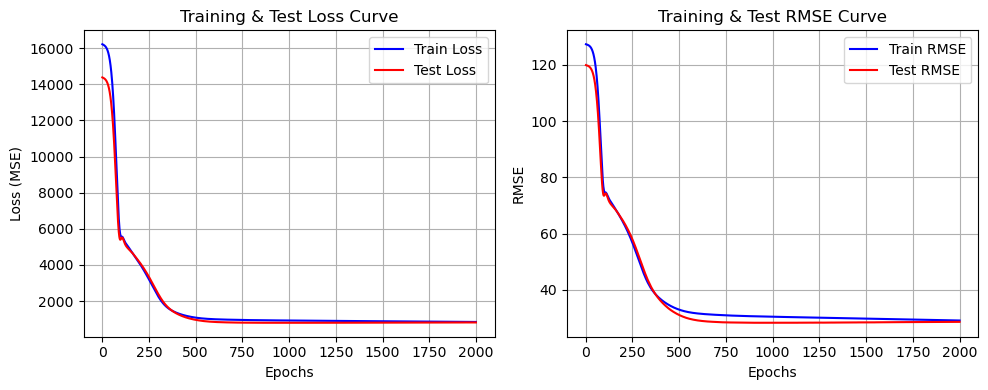

In [39]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label="Train Loss", color="blue")
plt.plot(range(1, epochs+1), test_losses, label="Test Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Test Loss Curve")
plt.legend()
plt.grid()


plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_rmse, label="Train RMSE", color="blue")
plt.plot(range(1, epochs+1), test_rmse, label="Test RMSE", color="red")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Training & Test RMSE Curve")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### Model Evaluation

In [40]:
model.eval()
y_pt=[]
y_gt = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        y_gt.extend(y_batch.cpu().detach().numpy().ravel().tolist())
        y_pt.extend(y_pred.cpu().detach().numpy().ravel().tolist())


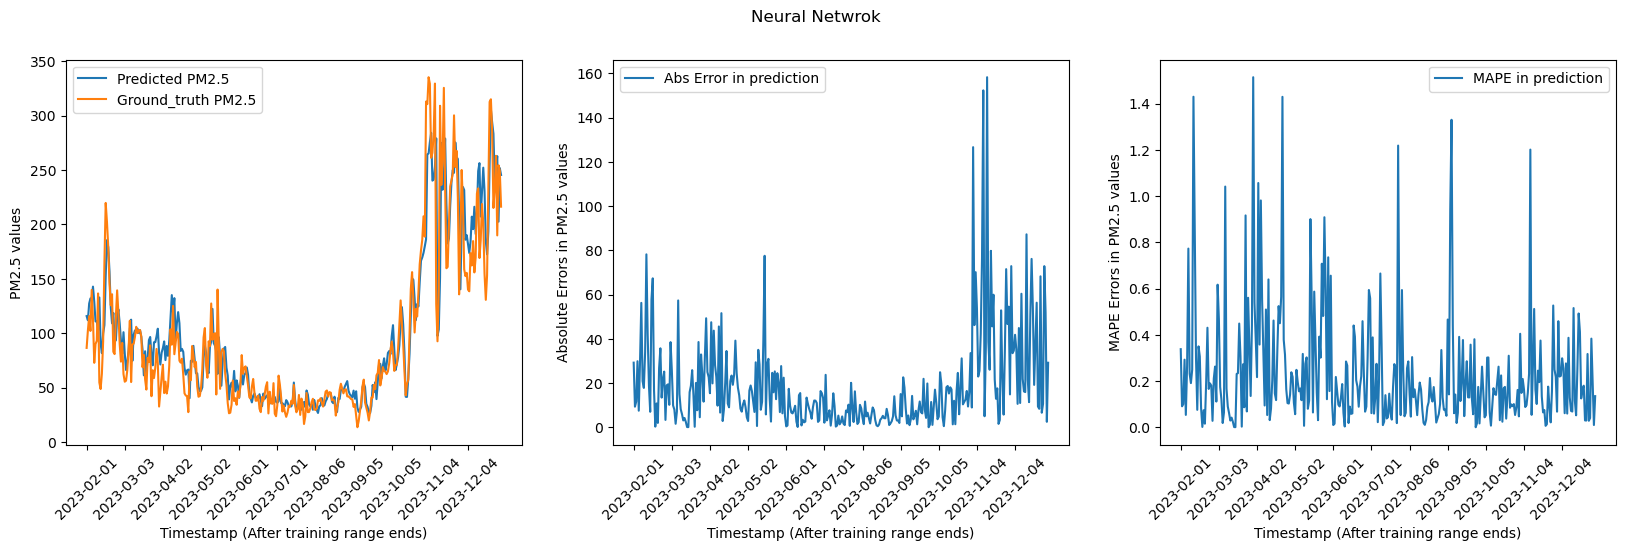

In [41]:
y_pt=np.array(y_pt)
y_gt = np.array(y_gt)
Errors = np.abs(y_gt-y_pt)
MAPE = np.abs(y_gt-y_pt)/y_gt


plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.plot(y_pt,label="Predicted PM2.5")
plt.plot(y_gt,label="Ground_truth PM2.5")
plt.ylabel("PM2.5 values")
plt.xlabel("Timestamp (After training range ends)")
ds = timestamp[len(Xtrain):].values
plt.xticks(range(0,len(Xtest),30),ds[::30],rotation =45)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(Errors , label = "Abs Error in prediction")
plt.ylabel("Absolute Errors in PM2.5 values")
plt.xlabel("Timestamp (After training range ends)")
ds = timestamp[len(Xtrain):].values
plt.xticks(range(0,len(Xtest),30),ds[::30],rotation =45)
plt.legend()


plt.subplot(1, 3, 3)
plt.plot(MAPE , label = "MAPE in prediction")
plt.ylabel("MAPE Errors in PM2.5 values")
plt.xlabel("Timestamp (After training range ends)")
ds = timestamp[len(Xtrain):].values
plt.xticks(range(0,len(Xtest),30),ds[::30],rotation =45)
plt.legend()

plt.suptitle("Neural Netwrok")
plt.show()